# Set Up

In [5]:
from torch_geometric.data import Data
from typing import List
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import torch_geometric.transforms as T

import sklearn.metrics as metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob
from PIL import Image

/Users/liyafasil/FindYourStyle/cv_proj/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
device = None

# check if MPS (Apple Silicon GPU) is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
# check if CUDA (NVIDIA GPU) is available
elif torch.cuda.is_available():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
else:
    device = torch.device("cpu")
    print ("MPS and CUDA device not found.")

# Load Data

In [7]:
IMAGE_DIR = "../data/images/"
SEGM_DIR = "../data/segm/"

In [8]:
# LOAD DATA

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
import numpy as np
from PIL import Image
import torch

from torch.utils.data import Dataset
import os
import numpy as np
from PIL import Image
import torch
from tqdm import tqdm # You might need to install this or remove if not available

class DeepFashionMultiItemDataset(Dataset):
    def __init__(self, img_dir, segm_dir, transform=None):
        self.img_dir = img_dir
        self.segm_dir = segm_dir
        self.transform = transform
        
        # --- MAPPING CONFIGURATION ---
        # Based on README "Human Parsing Label" table
        # We only care about main clothing, not 'hair'(13) or 'face'(14)
        self.target_map = {
            1: 0,  # 'top' -> class 0
            2: 1,  # 'outer' -> class 1
            3: 2,  # 'skirt' -> class 2
            4: 3,  # 'dress' -> class 3
            5: 4,  # 'pants' -> class 4
            6: 5,  # 'leggings' -> class 5
            21: 6  # 'rompers' -> class 6
        }
        # List of original IDs we want to find (1, 2, 3, 4, 5, 6, 21)
        self.interest_ids = set(self.target_map.keys())

        # --- PRE-SCANNING LOOP ---
        # We need to build a list of (image_name, specific_label_id)
        self.samples = []
        
        # Get all potential jpg files
        all_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        print(f"Pre-scanning {len(all_files)} images to find all clothing items...")
        
        # We use tqdm to show a progress bar because this might take a moment
        for img_name in tqdm(all_files):
            base_name = os.path.splitext(img_name)[0]
            segm_name = f"{base_name}_segm.png"
            segm_path = os.path.join(segm_dir, segm_name)
            
            if os.path.exists(segm_path):
                # Open the mask to see what's inside
                # We use PIL to open, then numpy to get unique values
                segm_np = np.array(Image.open(segm_path))
                unique_labels = np.unique(segm_np)
                
                # Check every label found in this image
                for label in unique_labels:
                    if label in self.interest_ids:
                        # FOUND ONE! Add a specific sample for this item
                        # We store: (filename, original_pixel_value_to_look_for)
                        self.samples.append((img_name, label))
                        
        print(f"Scanning complete. Created {len(self.samples)} samples from {len(all_files)} images.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # 1. Retrieve the specific pair we found during init
        img_name, original_id = self.samples[idx]
        
        # 2. Paths
        img_path = os.path.join(self.img_dir, img_name)
        base_name = os.path.splitext(img_name)[0]
        segm_path = os.path.join(self.segm_dir, f"{base_name}_segm.png")
        
        # 3. Load Data
        image = Image.open(img_path).convert('RGB')
        segm = np.array(Image.open(segm_path)) # Load mask as numpy array
        
        # 4. Create the Binary Mask for THIS specific item
        # We only want pixels that match 'original_id' (e.g., 5 for pants)
        # Result is 1.0 for pants, 0.0 for everything else (including top, background, etc.)
        mask_binary = (segm == original_id).astype(np.uint8)
        mask_img = Image.fromarray(mask_binary)
        
        # 5. Resize Mask to match Model Input (224x224)
        mask_img = mask_img.resize((224, 224), resample=Image.NEAREST)
        mask_tensor = torch.tensor(np.array(mask_img), dtype=torch.float32)
        
        # 6. Get the Model Target Label (0-6)
        target_label = self.target_map[original_id]
        
        # 7. Transform Image
        if self.transform:
            image = self.transform(image)
            
        return image, mask_tensor, torch.tensor(target_label)
    
     

# Setup Data Loaders
# Note: Resize to 224x224 is mandatory for ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Initialize
dataset = DeepFashionMultiItemDataset(IMAGE_DIR, SEGM_DIR, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

print(dataset[0][0].shape, dataset[0][1].shape, dataset[0][2])
print(dataset[20][0].shape, dataset[20][1].shape, dataset[20][2])

print(f"Dataset ready. Found {len(dataset)} images.")

Pre-scanning 44096 images to find all clothing items...


100%|██████████| 44096/44096 [00:41<00:00, 1050.65it/s]


Scanning complete. Created 25212 samples from 44096 images.
torch.Size([3, 224, 224]) torch.Size([224, 224]) tensor(0)
torch.Size([3, 224, 224]) torch.Size([224, 224]) tensor(4)
Dataset ready. Found 25212 images.


# Model 1


Image Classification Model Class

In [9]:
import torchvision.models as models

class FashionResNet(nn.Module):
    def __init__(self, num_classes=7):
        super(FashionResNet, self).__init__()
        # Load Pre-trained ResNet50
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # Replace the last layer (fc) to match our 7 classes
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_features, num_classes)
        
    def forward(self, x):
        return self.backbone(x)

model = FashionResNet().to(device)
print("Model initialized.")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/umasivakumar/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:02<00:00, 40.5MB/s]


Model initialized.


# Train

Hyperparameters

In [10]:
learning_rate = 1e-3
num_epochs = 10
criterion = nn.CrossEntropyLoss(ignore_index=-1) # Ignore images with no valid clothes
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:

# Normalization layer (applied AFTER masking)
normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

print("Starting Training...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, (images, masks, labels) in enumerate(train_loader):
        images, masks, labels = images.to(device), masks.to(device), labels.to(device)
        
        # --- THE FUSION STEP ---
        # 1. Expand mask to match image channels (Batch, 1, H, W) -> (Batch, 3, H, W)
        masks = masks.unsqueeze(1).repeat(1, 3, 1, 1)
        
        # 2. Black out background
        masked_images = images * masks
        
        # 3. Normalize
        model_inputs = normalizer(masked_images)
        
        # --- TRAINING ---
        optimizer.zero_grad()
        outputs = model(model_inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}], Loss: {loss.item():.4f}")

Starting Training...
Epoch [1/10], Step [0], Loss: 1.9641
Epoch [1/10], Step [10], Loss: 1.0841
Epoch [1/10], Step [20], Loss: 0.8223
Epoch [1/10], Step [30], Loss: 0.6900
Epoch [1/10], Step [40], Loss: 0.5800
Epoch [1/10], Step [50], Loss: 1.1158
Epoch [1/10], Step [60], Loss: 0.5409
Epoch [1/10], Step [70], Loss: 0.7451
Epoch [1/10], Step [80], Loss: 0.6690
Epoch [1/10], Step [90], Loss: 0.3492
Epoch [1/10], Step [100], Loss: 0.6492
Epoch [1/10], Step [110], Loss: 0.4514
Epoch [1/10], Step [120], Loss: 0.3463
Epoch [1/10], Step [130], Loss: 0.4657
Epoch [1/10], Step [140], Loss: 0.5125
Epoch [1/10], Step [150], Loss: 0.4072
Epoch [1/10], Step [160], Loss: 0.2289
Epoch [1/10], Step [170], Loss: 0.3808
Epoch [1/10], Step [180], Loss: 0.1581
Epoch [1/10], Step [190], Loss: 0.2320
Epoch [1/10], Step [200], Loss: 0.4166
Epoch [1/10], Step [210], Loss: 0.2171
Epoch [1/10], Step [220], Loss: 0.3513
Epoch [1/10], Step [230], Loss: 0.5127
Epoch [1/10], Step [240], Loss: 0.7014
Epoch [1/10], S

# Test

MSE: 0.1203
Accuracy: 97.84%


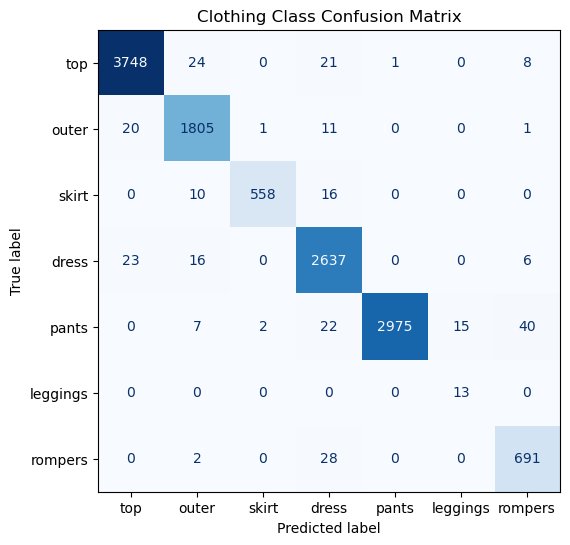

In [13]:
label_names = ['top', 'outer', 'skirt', 'dress', 'pants', 'leggings', 'rompers']

def evaluate_model(model, data_loader, device, normalizer, num_classes=7, label_names=None):
    model.eval()
    total_mse = 0.0
    total_samples = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, masks, labels in data_loader:
            valid_mask = labels != -1
            if valid_mask.sum() == 0:
                continue

            images = images[valid_mask].to(device)
            masks = masks[valid_mask].to(device)
            labels = labels[valid_mask].to(device)

            masks = masks.unsqueeze(1).repeat(1, 3, 1, 1)
            masked_images = images * masks
            model_inputs = normalizer(masked_images)

            outputs = model(model_inputs)
            preds = torch.argmax(outputs, dim=1)

            total_mse += F.mse_loss(preds.float(), labels.float(), reduction='sum').item()
            total_samples += labels.size(0)

            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    if total_samples == 0:
        print('No valid samples available for evaluation.')
        return

    mse = total_mse / total_samples
    accuracy = metrics.accuracy_score(all_labels, all_preds)
    class_indices = list(range(num_classes))
    conf_mat = metrics.confusion_matrix(all_labels, all_preds, labels=class_indices)
    display_labels = label_names if label_names is not None else [str(idx) for idx in class_indices]

    print(f"MSE: {mse:.4f}")
    print(f"Accuracy: {accuracy * 100:.2f}%")

    fig, ax = plt.subplots(figsize=(6, 6))
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=display_labels)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title('Clothing Class Confusion Matrix')
    plt.show()

# Run on the current training data loader
evaluate_model(model, train_loader, device, normalizer, num_classes=7, label_names=label_names)


# Model 2

In [ ]:
FABRIC_ANN_PATH = "../data/labels/texture/fabric_ann.txt"

fabric_ann = {}
with open(FABRIC_ANN_PATH, "r") as f:
    for line in f:
        parts = line.strip().split()
        img = parts[0]
        fabrics = list(map(int, parts[1:]))
        fabric_ann[img] = fabrics


# segmentation id -> region index in fabrics
segm_to_region = {
    1: "upper", 4: "upper", 21: "upper",  # top/dress/romper
    5: "lower", 6: "lower",               # pants/leggings
    2: "outer"                            # outerwear
}
region_idx = {"upper": 0, "lower": 1, "outer": 2}
ignore_fabric = 7  # matches your file’s ignore index



PermissionError: [Errno 13] Permission denied: '../data/labels/texture'

In [ ]:
class FabricPerMaskDataset(Dataset):
    def __init__(self, img_dir, segm_dir, fabric_ann, transform=None):
        self.img_dir = img_dir
        self.segm_dir = segm_dir
        self.fabric_ann = fabric_ann
        self.transform = transform
        self.samples = []
        all_imgs = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]
        for img in all_imgs:
            base = os.path.splitext(img)[0]
            segm_path = os.path.join(segm_dir, f"{base}_segm.png")
            if not os.path.exists(segm_path):
                continue
            segm_np = np.array(Image.open(segm_path))
            if img not in fabric_ann:
                continue
            fabrics = fabric_ann[img]
            for seg_id in [1,2,3,4,5,6,21]:
                if seg_id not in segm_to_region:
                    continue  # seg_id=3 (skirt) has no mapping above; add if you have labels
                mask = (segm_np == seg_id).astype(np.uint8)
                if mask.sum() == 0:
                    continue
                region = segm_to_region[seg_id]
                fab_label = fabrics[region_idx[region]]
                self.samples.append((img, seg_id, fab_label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, seg_id, fab_label = self.samples[idx]
        image = Image.open(os.path.join(self.img_dir, img_name)).convert("RGB")
        segm = Image.open(os.path.join(self.segm_dir, img_name.replace(".jpg", "_segm.png")))
        segm_np = np.array(segm)
        mask_np = (segm_np == seg_id).astype(np.uint8)
        mask_img = Image.fromarray(mask_np).resize((224, 224), Image.NEAREST)
        mask_t = torch.tensor(np.array(mask_img), dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, mask_t, torch.tensor(fab_label, dtype=torch.long)


In [ ]:
class FabricResNet(nn.Module):
    def __init__(self, num_classes=8):  # 0-6 fabrics + ignore=7 if you want to include it
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

fabric_model = FabricResNet(num_classes=8).to(device)


In [ ]:
fabric_loader = DataLoader(
    FabricPerMaskDataset(IMAGE_DIR, SEGM_DIR, fabric_ann, transform=transform),
    batch_size=32, shuffle=True
)

fabric_criterion = nn.CrossEntropyLoss(ignore_index=ignore_fabric)
fabric_optimizer = optim.Adam(fabric_model.parameters(), lr=1e-3)

for epoch in range(5):  # adjust
    fabric_model.train()
    for i, (images, masks, fab_labels) in enumerate(fabric_loader):
        images, masks, fab_labels = images.to(device), masks.to(device), fab_labels.to(device)
        masks = masks.unsqueeze(1).repeat(1, 3, 1, 1)  # expand mask
        masked_images = images * masks
        inputs = normalizer(masked_images)
        logits = fabric_model(inputs)
        loss = fabric_criterion(logits, fab_labels)
        fabric_optimizer.zero_grad()
        loss.backward()
        fabric_optimizer.step()
        if i % 20 == 0:
            print(f"Epoch {epoch+1} Step {i} Loss {loss.item():.4f}")
